In [14]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

# in a notebook, load the tensorboard extension, not needed for scripts
%load_ext tensorboard

# load the mnist dataset
# (train_ds, test_ds) = tfds.load('Cifar10', split=['train', 'test'], as_supervised=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# def prepare(batch_size, data, augmentation = None):
#   data = data.map(lambda img, target: (tf.cast(img, tf.float32), tf.cast(target, tf.int32)))
#   #bring the values into a range between -1 and 1
#   data = data.map(lambda img, target: ((img/255), target))
#   data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
#   data = data.cache()
#   data = data.shuffle(1000)
#   data = data.batch(batch_size)

#   if augmentation:
#     #data = data.map(lambda img, target: (tf.image.adjust_brightness(img, delta = 0.1), target))
#     #data = data.map(lambda img, target: (tf.image.adjust_saturation(img, saturation_factor = 0.2, name = None), target))
#     #data = data.map(lambda img, target: (tf.image.flip_left_right(img), target))
    

#   data = data.prefetch(tf.data.AUTOTUNE)

#   return data


In [13]:
def prepare_data(batch_size, augmentation = None): 
    '''
    prepare the dataset to have one-hot-vectors and values between -1 and 1
    '''
    train_ds, test_ds = tfds.load('Cifar10', split=['train', 'test'], as_supervised=True)
    
    prep_func = lambda img, t: (tf.cast(img, tf.float32)/255.,tf.one_hot(tf.cast(t,tf.int32), depth=10))
    train_ds = train_ds.map(prep_func).cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(prep_func).cache().shuffle(1028).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.3)])
    
    if augmentation:
        train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls=tf.data.AUTOTUNE)
        
    return train_ds, test_ds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteUACSWQ/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteUACSWQ/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


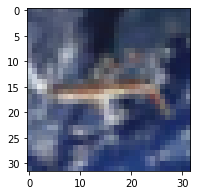

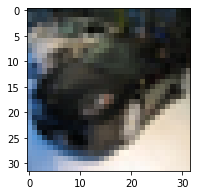

In [ ]:
train, test = prepare_data(32, True)

train = list(train.take(1))
test = list(test.take(1))

for img in [train, test]: 
    plt.figure(figsize=(3,3))
    plt.imshow(img[0][0][0])
    plt.show()

In [ ]:
from tensorflow.keras.layers import Dense

class BasicConv(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self, optimizer = tf.keras.optimizers.Adam(), L2_norm = 0, L1_norm = 0, dropout_rate=0, batch_norm = None,label_smoothing=0):
    super(BasicConv, self).__init__()

    if L2_norm:
      kernel_regularizer=tf.keras.regularizers.L2(L2_norm)
    elif L1_norm:
      kernel_regularizer=tf.keras.regularizers.L1(L1_norm)
    else:
      kernel_regularizer=None

    self.dropout_rate = dropout_rate

    if self.dropout_rate: 
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.Mean(name = "frobenius"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    
    self.layer_list =  [tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.GlobalAvgPool2D(),
                        tf.keras.layers.Dense(10, activation = 'softmax')]
                        
    if batch_norm: 
      self.layer_list.insert(1,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(3,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(6,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(8,tf.keras.layers.BatchNormalization())


  def call(self, x , training = False):
    for layer in self.layer_list[:-1]:
      x = layer(x)
      if self.dropout_rate:
        x = self.dropout_layer(x,training)
    return self.layer_list[-1](x)

    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l1(x)
    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l2(x)
    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l3(x)
    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l4(x)
    # x = self.global_pool(x)
    # x = self.out(x)

  

  @property
  def metrics(self):
    return self.metrics_list


  def reset_metrics(self):
    for metric in self.metrics: 
      metric.reset_states()

  def compute_frobenius(self): 
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables: 
      frobenius_norm += tf.norm(var, ord = "euclidean")
    return frobenius_norm

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}







In [5]:
from tensorflow.keras.layers import Dense

class DeepConv(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self, optimizer = tf.keras.optimizers.Adam(), L2_norm = 0, L1_norm = 0, dropout_rate=0, batch_norm = None,label_smoothing=0):
    super(DeepConv, self).__init__()

    if L2_norm:
      kernel_regularizer=tf.keras.regularizers.L2(L2_norm)
    elif L1_norm:
      kernel_regularizer=tf.keras.regularizers.L1(L1_norm)
    else:
      kernel_regularizer=None

    self.dropout_rate = dropout_rate

    if self.dropout_rate: 
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.Mean(name = "frobenius"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    
    self.layer_list =  [tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                        tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = kernel_regularizer),
                        tf.keras.layers.GlobalAvgPool2D(),
                        tf.keras.layers.Dense(10, activation = 'softmax')]
                        
    if batch_norm: 
      self.layer_list.insert(1,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(3,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(6,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(8,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(11,tf.keras.layers.BatchNormalization())
      self.layer_list.insert(13,tf.keras.layers.BatchNormalization())



  def call(self, x , training = False):
    for layer in self.layer_list[:-1]:
      x = layer(x)
      if self.dropout_rate:
        x = self.dropout_layer(x,training)
    return self.layer_list[-1](x)

    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l1(x)
    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l2(x)
    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l3(x)
    # x = self.dropout_layer(x, training) if self.dropout_rate else self.l4(x)
    # x = self.global_pool(x)
    # x = self.out(x)

  

  @property
  def metrics(self):
    return self.metrics_list


  def reset_metrics(self):
    for metric in self.metrics: 
      metric.reset_states()

  def compute_frobenius(self): 
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables: 
      frobenius_norm += tf.norm(var, ord = "euclidean")
    return frobenius_norm

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}







In [ ]:
class ResidualConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, depth, L1_norm, L2_norm):
    super(ResidualConnectedCNNLayer, self).__init__()

    if L2_norm:
      kernel_regularizer=tf.keras.regularizers.L2(L2_norm)
    elif L1_norm:
      kernel_regularizer=tf.keras.regularizers.L1(L1_norm)
    else:
      kernel_regularizer=None

    self.conv = tf.keras.layers.Conv2D(filters=depth, kernel_size=3, padding='same', activation='relu', kernel_regularizer = kernel_regularizer)

  def call(self, x):
    c = self.conv(x)
    #residual connection 
    x = c+x
    return x

class ResidualConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, depth, layers, L1_norm = 0, L2_norm = 0, dropout_rate = 0):
    super(ResidualConnectedCNNBlock, self).__init__()

    if L2_norm:
      kernel_regularizer=tf.keras.regularizers.L2(L2_norm)
    elif L1_norm:
      kernel_regularizer=tf.keras.regularizers.L1(L1_norm)
    else:
      kernel_regularizer=None


    self.dropout_rate = dropout_rate

    if self.dropout_rate:
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    #depth increases in the end of the network (cannot add them with different sizes)
    #specify the depth such that they get the same depth 
    self.deeper_layer = tf.keras.layers.Conv2D(filters=depth, kernel_size=3, padding='same', activation='relu', kernel_regularizer = kernel_regularizer)
    #list with many residual connected cnn layer
    self.layers = [ResidualConnectedCNNLayer(depth, L1_norm, L2_norm) for _ in range(layers)]

  def call(self, x, training = False):
    #bring it to the correct depth 
    x = self.deeper_layer(x)
    for layer in self.layers:
      x = layer(x)
      if self.dropout_rate: 
        x = self.dropout_layer(x, training)
    return x


class ResidualConnectedCNN(tf.keras.Model):
  def __init__(self, optimizer = tf.keras.optimizers.Adam(),L1_norm = 0, L2_norm = 0, batch_norm = False,dropout_rate=0,label_smoothing=0):
    super(ResidualConnectedCNN, self).__init__()
    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.Mean(name = "total_frobenius_norm"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    # self.loss_metric = tf.keras.metrics.Mean(name="loss")
    # self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="acc")
    # self.frobenius_metric = tf.keras.metrics.Mean(name = "total_frobenius_norm")

    self.block_list = [ResidualConnectedCNNBlock(24,4,L1_norm = L1_norm, L2_norm = L2_norm,dropout_rate = dropout_rate),
                       tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                       ResidualConnectedCNNBlock(48,4, L1_norm = L1_norm, L2_norm = L2_norm,dropout_rate = dropout_rate),
                       tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
                       ResidualConnectedCNNBlock(96,4, L1_norm = L1_norm, L2_norm = L2_norm,dropout_rate = dropout_rate),
                       tf.keras.layers.GlobalAvgPool2D()]
    self.out = tf.keras.layers.Dense(10, activation='softmax')

    if batch_norm: 
      self.block_list.insert(1,tf.keras.layers.BatchNormalization())
      self.block_list.insert(4,tf.keras.layers.BatchNormalization())
      self.block_list.insert(7,tf.keras.layers.BatchNormalization())
    

  def call(self,x):
    for block in self.block_list:
      x = block(x)
      
    return self.out(x)

  def compute_frobenius(self): 
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables: 
      frobenius_norm += tf.norm(var, ord = "euclidean")
    return frobenius_norm

  @property
  def metrics(self):
    return self.metrics_list

  def reset_metrics(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}


In [ ]:
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filter, L1_norm = 0, L2_norm = 0): 
    super(DenselyConnectedCNNLayer, self).__init__()

    if L2_norm:
      kernel_regularizer=tf.keras.regularizers.L2(L2_norm)
    elif L1_norm:
      kernel_regularizer=tf.keras.regularizers.L1(L1_norm)
    else:
      kernel_regularizer=None
  

    self.conv = tf.keras.layers.Conv2D(filters = num_filter, kernel_size = 3, padding = "same", activation = "relu", kernel_regularizer = kernel_regularizer)

  def call(self,x): 
    c = self.conv(x)
    #concatenate at last layer - get long stack of all earlier layer
    x = tf.concat((x,c), axis = -1)
    return x


class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  #take all conv layers and create a block we take for one convolution
  def __init__(self, num_filters, layers, L1_norm = 0, L2_norm = 0, dropout_rate = 0):
    super(DenselyConnectedCNNBlock, self).__init__()
    self.dropout_rate = dropout_rate

    if self.dropout_rate:
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    self.layers = [DenselyConnectedCNNLayer(num_filters, L1_norm, L2_norm) for _ in range(layers)]


  def call(self, x, training = False): 
    #take input and pump it through all layers we have 
    for l in self.layers:
      x = l(x)
      if self.dropout_rate: 
        x = self.dropout_layer(x, training)
    return x


class DenselyConnectedCNN(tf.keras.Model):
  def __init__(self, optimizer = tf.keras.optimizers.Adam(), L1_norm=0,L2_norm=0,batch_norm = False,dropout_rate=0,label_smoothing=0):
    super(DenselyConnectedCNN, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    self.metrics_list = [tf.keras.metrics.Mean(name = "loss"),
                         tf.keras.metrics.Mean(name = "total_frobenius_norm"),
                         tf.keras.metrics.CategoricalAccuracy(name = "acc")]

    #4 layers with each of 24 kernels -> get 4 layer in 28*28 resolution 
    self.block_list = [DenselyConnectedCNNBlock(24,4,L1_norm = L1_norm, L2_norm = L2_norm,dropout_rate = dropout_rate),
                       tf.keras.layers.MaxPooling2D(),
                       DenselyConnectedCNNBlock(24,4,L1_norm = L1_norm, L2_norm = L2_norm,dropout_rate = dropout_rate),
                       tf.keras.layers.MaxPooling2D(),
                       DenselyConnectedCNNBlock(24,4, L1_norm = L1_norm, L2_norm = L2_norm,dropout_rate = dropout_rate),
                       tf.keras.layers.GlobalAvgPool2D()]
    self.out = tf.keras.layers.Dense(10, activation='softmax')

    
    if batch_norm: 
      self.block_list.insert(1,tf.keras.layers.BatchNormalization())
      self.block_list.insert(4,tf.keras.layers.BatchNormalization())
      self.block_list.insert(7,tf.keras.layers.BatchNormalization())
    
  def call(self,x):
    for block in self.block_list:
      x = block(x)
      
    return self.out(x)

  @property
  def metrics(self):
    return self.metrics_list

  def compute_frobenius(self): 
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables: 
      frobenius_norm += tf.norm(var, ord = "euclidean")
    return frobenius_norm

  def reset_metrics(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    self.metrics[1].update_state(self.compute_frobenius())
    
    for metric in self.metrics[2:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}


In [6]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer): 
  #iterate over given amount of epochs
  for epoch in range(epochs): 
    print(f"Epoch {epoch}: ")

    for data in tqdm.tqdm(train_ds, position=0, leave = True): 

      metrics = model.train_step(data)

      with train_summary_writer.as_default(): 
        for metric in model.metrics: 
          tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)


    # print the metrics
    print([f"Train {key}: {value.numpy()}" for (key, value) in metrics.items()])
    

    #reset metric 
    model.reset_metrics()
  
    #evaluation on validation set
    for data in val_ds:
      metrics = model.test_step(data)

      with val_summary_writer.as_default():
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
      
    # print the metrics
    print([f"Test {key}: {value.numpy()}" for (key, value) in metrics.items()])

    #reset metric
    model.reset_metrics()

    print("\n")

In [ ]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer): 
    '''
    create the training loop where the model is trained on the train dataset and afterwards tested on the validation dataset
    '''
    hist = {"train_loss":[],"train_acc":[],"test_loss":[], "test_acc":[]}
    #iterate over given amount of epochs
    for epoch in range(epochs): 
        print(f"Epoch {epoch}: ")

        #train on all batches of the training data
        for data in tqdm.tqdm(train_ds, position = 0, leave = True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default(): 
                for metric in model.metrics: 
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"train_{key}"].append(value.numpy())
            print(f"train_{key}: {value.numpy()}")

        #reset metric 
        model.reset_metrics()

        #evaluation on validation set
        for data in val_ds:
            metrics = model.test_step(data)

            with val_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics and add to history element
        for key, value in metrics.items():
            hist[f"test_{key}"].append(value.numpy())
            print(f"test_{key}: {value.numpy()}")

        #reset metric
        model.reset_metric()
        print("\n")
    
    return hist

In [7]:
def create_summary_writers(config_name):
  '''
  create the summary writer to have access to the metrics of the model 
  '''
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  train_log_path = f"logs/submission/{config_name}/{current_time}/train"
  val_log_path = f"logs/submission/{config_name}/{current_time}/val"

  # log writer
  train_summary_writer = tf.summary.create_file_writer(train_log_path)
  val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
  return train_summary_writer, val_summary_writer

In [17]:
def run(model,num_epochs=15,save=True,load=False,config_name = f'RUN',augmentation=False):
  '''
  run the model and specify the number of epochs, batch_size and prepare the training and testing data
  '''

  ### Hyperparameters
  num_epochs = num_epochs
  batch_size = 32
  train,test = prepare_data(batch_size,augmentation=augmentation)
  
  
  train_summary_writer, val_summary_writer = create_summary_writers(config_name)


  if load:
    model.load_weights(f"saved_model_{config_name}");

  hist = training_loop(model,train,test,num_epochs,train_summary_writer, val_summary_writer)
  if save:
    model.save_weights(f"saved_model_{config_name}", save_format="tf")


  
    
  fig, ax = plt.subplots(1,2, figsize=(10,10))

  ax[0].plot(hist['train_acc'], label='train accuracy')
  ax[0].plot(hist['test_acc'], label='test accuracy')
  ax[0].legend()

  ax[1].plot(hist['train_loss'], label='train loss')
  ax[1].plot(hist['test_loss'], label='test loss')
  ax[1].legend();

In [ ]:
myMod1 = BasicConv(tf.keras.optimizers.Adam(), L1_norm = 0.4, batch_norm = True, dropout_rate=0,label_smoothing=0.1)

print("Basic Convolutional Network, optimizer=Adam, L1 regularizer, dropout layers")
run(myMod1,1,config_name = f'BASIC1')

In [ ]:
myMod2 = DeepConv(tf.keras.optimizers.Adam(), L1_norm = 0.2, batch_norm =True, dropout_rate=0.1,label_smoothing=0.01)

print("Basic Convolutional Network, optimizer=Adam, L1 regularizer, dropout layers")
run(myMod2,100,save=False,config_name = f'DEEP1',augmentation=True)

Basic Convolutional Network, optimizer=Adam, L1 regularizer, dropout layers
Epoch 0: 


100%|██████████| 1563/1563 [00:40<00:00, 38.67it/s]


['Train loss: 1.7550135850906372', 'Train frobenius: 105.85831451416016', 'Train acc: 0.36875998973846436']
['Test loss: 2.1551434993743896', 'Test frobenius: 113.14630126953125', 'Test acc: 0.31619998812675476']


Epoch 1: 


100%|██████████| 1563/1563 [00:37<00:00, 42.15it/s]


['Train loss: 1.5130109786987305', 'Train frobenius: 121.00579071044922', 'Train acc: 0.46272000670433044']
['Test loss: 1.5307250022888184', 'Test frobenius: 128.65985107421875', 'Test acc: 0.47110000252723694']


Epoch 2: 


100%|██████████| 1563/1563 [00:36<00:00, 43.09it/s]


['Train loss: 1.395881175994873', 'Train frobenius: 136.17257690429688', 'Train acc: 0.5094000101089478']
['Test loss: 1.5533561706542969', 'Test frobenius: 143.3436737060547', 'Test acc: 0.4758000075817108']


Epoch 3: 


100%|██████████| 1563/1563 [00:35<00:00, 43.85it/s]


['Train loss: 1.3191763162612915', 'Train frobenius: 150.0686798095703', 'Train acc: 0.5418400168418884']
['Test loss: 1.5558875799179077', 'Test frobenius: 156.5908966064453', 'Test acc: 0.46959999203681946']


Epoch 4: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 1.2640129327774048', 'Train frobenius: 162.60523986816406', 'Train acc: 0.5607799887657166']
['Test loss: 1.3597612380981445', 'Test frobenius: 168.3681182861328', 'Test acc: 0.5310999751091003']


Epoch 5: 


100%|██████████| 1563/1563 [00:35<00:00, 43.51it/s]


['Train loss: 1.220068335533142', 'Train frobenius: 173.98834228515625', 'Train acc: 0.5796399712562561']
['Test loss: 1.3022205829620361', 'Test frobenius: 179.57029724121094', 'Test acc: 0.5602999925613403']


Epoch 6: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 1.1888571977615356', 'Train frobenius: 184.6574249267578', 'Train acc: 0.5904399752616882']
['Test loss: 1.2219041585922241', 'Test frobenius: 189.62399291992188', 'Test acc: 0.5821999907493591']


Epoch 7: 


100%|██████████| 1563/1563 [00:35<00:00, 43.88it/s]


['Train loss: 1.168203353881836', 'Train frobenius: 194.5062713623047', 'Train acc: 0.599560022354126']
['Test loss: 1.1712971925735474', 'Test frobenius: 199.17962646484375', 'Test acc: 0.607200026512146']


Epoch 8: 


100%|██████████| 1563/1563 [00:38<00:00, 40.47it/s]


['Train loss: 1.1343902349472046', 'Train frobenius: 203.6898193359375', 'Train acc: 0.6114799976348877']
['Test loss: 1.1997822523117065', 'Test frobenius: 208.17189025878906', 'Test acc: 0.5910999774932861']


Epoch 9: 


100%|██████████| 1563/1563 [00:35<00:00, 44.35it/s]


['Train loss: 1.1140711307525635', 'Train frobenius: 212.37527465820312', 'Train acc: 0.6215999722480774']
['Test loss: 1.1381086111068726', 'Test frobenius: 216.43252563476562', 'Test acc: 0.6118000149726868']


Epoch 10: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 1.1031643152236938', 'Train frobenius: 220.46644592285156', 'Train acc: 0.6251199841499329']
['Test loss: 1.191435694694519', 'Test frobenius: 224.5112762451172', 'Test acc: 0.5985000133514404']


Epoch 11: 


100%|██████████| 1563/1563 [00:41<00:00, 38.05it/s]


['Train loss: 1.088219404220581', 'Train frobenius: 228.24896240234375', 'Train acc: 0.6302800178527832']
['Test loss: 1.1770625114440918', 'Test frobenius: 231.92259216308594', 'Test acc: 0.605400025844574']


Epoch 12: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 1.0719906091690063', 'Train frobenius: 235.7054901123047', 'Train acc: 0.6353200078010559']
['Test loss: 1.1437644958496094', 'Test frobenius: 239.2310333251953', 'Test acc: 0.6169000267982483']


Epoch 13: 


100%|██████████| 1563/1563 [00:35<00:00, 43.45it/s]


['Train loss: 1.0610755681991577', 'Train frobenius: 242.76321411132812', 'Train acc: 0.6414200067520142']
['Test loss: 1.1764400005340576', 'Test frobenius: 246.28057861328125', 'Test acc: 0.6075000166893005']


Epoch 14: 


100%|██████████| 1563/1563 [00:35<00:00, 44.44it/s]


['Train loss: 1.0565773248672485', 'Train frobenius: 249.72731018066406', 'Train acc: 0.643559992313385']
['Test loss: 1.2693469524383545', 'Test frobenius: 253.1945343017578', 'Test acc: 0.5710999965667725']


Epoch 15: 


100%|██████████| 1563/1563 [00:35<00:00, 43.53it/s]


['Train loss: 1.03623366355896', 'Train frobenius: 256.5106201171875', 'Train acc: 0.6497600078582764']
['Test loss: 1.1467669010162354', 'Test frobenius: 259.6302795410156', 'Test acc: 0.6244999766349792']


Epoch 16: 


100%|██████████| 1563/1563 [00:35<00:00, 44.15it/s]


['Train loss: 1.0326321125030518', 'Train frobenius: 262.9592590332031', 'Train acc: 0.6517000198364258']
['Test loss: 1.1464242935180664', 'Test frobenius: 265.9969787597656', 'Test acc: 0.6233000159263611']


Epoch 17: 


100%|██████████| 1563/1563 [00:35<00:00, 43.73it/s]


['Train loss: 1.0164204835891724', 'Train frobenius: 269.3172912597656', 'Train acc: 0.6579599976539612']
['Test loss: 1.0736463069915771', 'Test frobenius: 272.2890930175781', 'Test acc: 0.6389999985694885']


Epoch 18: 


100%|██████████| 1563/1563 [00:36<00:00, 42.60it/s]


['Train loss: 1.0191980600357056', 'Train frobenius: 275.4630126953125', 'Train acc: 0.6569799780845642']
['Test loss: 1.1266512870788574', 'Test frobenius: 278.5024108886719', 'Test acc: 0.6297000050544739']


Epoch 19: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 1.0045346021652222', 'Train frobenius: 281.5091857910156', 'Train acc: 0.6632400155067444']
['Test loss: 1.093546748161316', 'Test frobenius: 284.3650207519531', 'Test acc: 0.6340000033378601']


Epoch 20: 


100%|██████████| 1563/1563 [00:35<00:00, 44.35it/s]


['Train loss: 1.0049397945404053', 'Train frobenius: 287.3288879394531', 'Train acc: 0.6629999876022339']
['Test loss: 1.05251944065094', 'Test frobenius: 290.012939453125', 'Test acc: 0.6518999934196472']


Epoch 21: 


100%|██████████| 1563/1563 [00:41<00:00, 38.07it/s]


['Train loss: 0.9958073496818542', 'Train frobenius: 292.9557189941406', 'Train acc: 0.6650599837303162']
['Test loss: 1.0390172004699707', 'Test frobenius: 295.7654724121094', 'Test acc: 0.6473000049591064']


Epoch 22: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.9868081212043762', 'Train frobenius: 298.6612243652344', 'Train acc: 0.6683200001716614']
['Test loss: 1.0618075132369995', 'Test frobenius: 301.5052795410156', 'Test acc: 0.6460999846458435']


Epoch 23: 


100%|██████████| 1563/1563 [00:35<00:00, 43.61it/s]


['Train loss: 0.9770427346229553', 'Train frobenius: 304.17254638671875', 'Train acc: 0.6723600029945374']
['Test loss: 1.2082173824310303', 'Test frobenius: 306.90618896484375', 'Test acc: 0.6144000291824341']


Epoch 24: 


100%|██████████| 1563/1563 [00:35<00:00, 44.43it/s]


['Train loss: 0.9736402034759521', 'Train frobenius: 309.6049499511719', 'Train acc: 0.6744199991226196']
['Test loss: 0.998740017414093', 'Test frobenius: 312.1927490234375', 'Test acc: 0.6703000068664551']


Epoch 25: 


100%|██████████| 1563/1563 [00:37<00:00, 41.29it/s]


['Train loss: 0.9706475734710693', 'Train frobenius: 314.71453857421875', 'Train acc: 0.6754000186920166']
['Test loss: 1.0897916555404663', 'Test frobenius: 317.2445983886719', 'Test acc: 0.6427000164985657']


Epoch 26: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 0.9666680693626404', 'Train frobenius: 319.79705810546875', 'Train acc: 0.6777999997138977']
['Test loss: 1.010535717010498', 'Test frobenius: 322.3179016113281', 'Test acc: 0.6603000164031982']


Epoch 27: 


100%|██████████| 1563/1563 [00:36<00:00, 43.03it/s]


['Train loss: 0.9563980102539062', 'Train frobenius: 324.8113098144531', 'Train acc: 0.6801400184631348']
['Test loss: 0.995762050151825', 'Test frobenius: 327.3592224121094', 'Test acc: 0.6717000007629395']


Epoch 28: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 0.9530737400054932', 'Train frobenius: 329.92236328125', 'Train acc: 0.6821200251579285']
['Test loss: 0.9770217537879944', 'Test frobenius: 332.37310791015625', 'Test acc: 0.6765999794006348']


Epoch 29: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 0.9515612721443176', 'Train frobenius: 334.8370361328125', 'Train acc: 0.6797599792480469']
['Test loss: 0.9672732353210449', 'Test frobenius: 337.09149169921875', 'Test acc: 0.6794000267982483']


Epoch 30: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.9493729472160339', 'Train frobenius: 339.5521545410156', 'Train acc: 0.6836599707603455']
['Test loss: 0.9899492859840393', 'Test frobenius: 341.8353576660156', 'Test acc: 0.6726999878883362']


Epoch 31: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.9421850442886353', 'Train frobenius: 344.2629699707031', 'Train acc: 0.6876599788665771']
['Test loss: 1.0441731214523315', 'Test frobenius: 346.5698547363281', 'Test acc: 0.6514999866485596']


Epoch 32: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.9319517016410828', 'Train frobenius: 349.0814208984375', 'Train acc: 0.6906200051307678']
['Test loss: 0.9751249551773071', 'Test frobenius: 351.3689270019531', 'Test acc: 0.6717000007629395']


Epoch 33: 


100%|██████████| 1563/1563 [00:35<00:00, 43.49it/s]


['Train loss: 0.9337105751037598', 'Train frobenius: 353.66986083984375', 'Train acc: 0.6900399923324585']
['Test loss: 1.0404061079025269', 'Test frobenius: 355.9904479980469', 'Test acc: 0.6547999978065491']


Epoch 34: 


100%|██████████| 1563/1563 [00:35<00:00, 43.82it/s]


['Train loss: 0.9260905981063843', 'Train frobenius: 358.3252258300781', 'Train acc: 0.690559983253479']
['Test loss: 0.9693667888641357', 'Test frobenius: 360.5256652832031', 'Test acc: 0.6794999837875366']


Epoch 35: 


100%|██████████| 1563/1563 [00:41<00:00, 38.09it/s]


['Train loss: 0.9298020005226135', 'Train frobenius: 362.73309326171875', 'Train acc: 0.6902400255203247']
['Test loss: 0.9934698343276978', 'Test frobenius: 364.7189025878906', 'Test acc: 0.6786999702453613']


Epoch 36: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 0.921915590763092', 'Train frobenius: 367.08056640625', 'Train acc: 0.6934199929237366']
['Test loss: 0.9813740253448486', 'Test frobenius: 369.25042724609375', 'Test acc: 0.6790000200271606']


Epoch 37: 


100%|██████████| 1563/1563 [00:35<00:00, 44.06it/s]


['Train loss: 0.9186348915100098', 'Train frobenius: 371.50982666015625', 'Train acc: 0.6940400004386902']
['Test loss: 0.9929600954055786', 'Test frobenius: 373.7361145019531', 'Test acc: 0.6754999756813049']


Epoch 38: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 0.9214507341384888', 'Train frobenius: 375.86376953125', 'Train acc: 0.6935200095176697']
['Test loss: 1.0575815439224243', 'Test frobenius: 377.9451904296875', 'Test acc: 0.6492000222206116']


Epoch 39: 


100%|██████████| 1563/1563 [00:36<00:00, 42.60it/s]


['Train loss: 0.9148547649383545', 'Train frobenius: 380.18121337890625', 'Train acc: 0.6944199800491333']
['Test loss: 0.9259074926376343', 'Test frobenius: 382.2890930175781', 'Test acc: 0.6947000026702881']


Epoch 40: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.9133115410804749', 'Train frobenius: 384.369873046875', 'Train acc: 0.6940600275993347']
['Test loss: 0.9291601181030273', 'Test frobenius: 386.342041015625', 'Test acc: 0.6967999935150146']


Epoch 41: 


100%|██████████| 1563/1563 [00:36<00:00, 43.24it/s]


['Train loss: 0.9069600105285645', 'Train frobenius: 388.4626770019531', 'Train acc: 0.69896000623703']
['Test loss: 0.9341790676116943', 'Test frobenius: 390.5157470703125', 'Test acc: 0.6947000026702881']


Epoch 42: 


100%|██████████| 1563/1563 [00:41<00:00, 38.10it/s]


['Train loss: 0.9038214683532715', 'Train frobenius: 392.4776916503906', 'Train acc: 0.6993799805641174']
['Test loss: 0.973077654838562', 'Test frobenius: 394.4626159667969', 'Test acc: 0.6844000220298767']


Epoch 43: 


100%|██████████| 1563/1563 [00:36<00:00, 43.28it/s]


['Train loss: 0.9045334458351135', 'Train frobenius: 396.56903076171875', 'Train acc: 0.7010800242424011']
['Test loss: 0.917121171951294', 'Test frobenius: 398.4297180175781', 'Test acc: 0.6967999935150146']


Epoch 44: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.8949931263923645', 'Train frobenius: 400.5504150390625', 'Train acc: 0.7052800059318542']
['Test loss: 0.9263420701026917', 'Test frobenius: 402.6233825683594', 'Test acc: 0.6949999928474426']


Epoch 45: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.896255612373352', 'Train frobenius: 404.6058349609375', 'Train acc: 0.7046999931335449']
['Test loss: 0.9748662114143372', 'Test frobenius: 406.5391540527344', 'Test acc: 0.6807000041007996']


Epoch 46: 


100%|██████████| 1563/1563 [00:35<00:00, 43.70it/s]


['Train loss: 0.895940899848938', 'Train frobenius: 408.4576110839844', 'Train acc: 0.7042999863624573']
['Test loss: 1.005096435546875', 'Test frobenius: 410.32183837890625', 'Test acc: 0.6722000241279602']


Epoch 47: 


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]


['Train loss: 0.8974931836128235', 'Train frobenius: 412.3427734375', 'Train acc: 0.7024199962615967']
['Test loss: 0.9681301116943359', 'Test frobenius: 414.0952453613281', 'Test acc: 0.6787999868392944']


Epoch 48: 


100%|██████████| 1563/1563 [00:35<00:00, 43.71it/s]


['Train loss: 0.8897035121917725', 'Train frobenius: 416.0400695800781', 'Train acc: 0.7062000036239624']
['Test loss: 0.9340289831161499', 'Test frobenius: 417.8730773925781', 'Test acc: 0.6934000253677368']


Epoch 49: 


 38%|███▊      | 590/1563 [00:13<00:30, 31.53it/s]

In [ ]:
myMod2 = DeepConv(tf.keras.optimizers.Adam(), L2_norm = 0.2, batch_norm = True, dropout_rate=0.1,label_smoothing=0.01)

print("Basic Convolutional Network, optimizer=Adam, L1 regularizer, dropout layers")
run(myMod2,40,save=False,config_name = f'DEEP1',augmentation=False)

Basic Convolutional Network, optimizer=Adam, L1 regularizer, dropout layers
Epoch 0: 


100%|██████████| 1172/1172 [00:15<00:00, 74.36it/s]


['Train loss: 1.3874751329421997', 'Train frobenius: 105.62710571289062', 'Train acc: 0.5083733201026917']
['Test loss: 1.366857886314392', 'Test frobenius: 112.98002624511719', 'Test acc: 0.5123999714851379']


Epoch 1: 


100%|██████████| 1172/1172 [00:11<00:00, 105.82it/s]


['Train loss: 1.029874324798584', 'Train frobenius: 119.77091979980469', 'Train acc: 0.649066686630249']
['Test loss: 0.9985197186470032', 'Test frobenius: 126.29524230957031', 'Test acc: 0.6552000045776367']


Epoch 2: 


100%|██████████| 1172/1172 [00:20<00:00, 57.27it/s] 


['Train loss: 0.8959730863571167', 'Train frobenius: 132.29934692382812', 'Train acc: 0.7019733190536499']
['Test loss: 0.8958852291107178', 'Test frobenius: 138.18714904785156', 'Test acc: 0.6895999908447266']


Epoch 3: 


100%|██████████| 1172/1172 [00:10<00:00, 106.88it/s]


['Train loss: 0.8186823725700378', 'Train frobenius: 143.89137268066406', 'Train acc: 0.7315733432769775']
['Test loss: 0.8550821542739868', 'Test frobenius: 149.46287536621094', 'Test acc: 0.7279999852180481']


Epoch 4: 


100%|██████████| 1172/1172 [00:10<00:00, 106.93it/s]


['Train loss: 0.7587299942970276', 'Train frobenius: 154.6295928955078', 'Train acc: 0.7545066475868225']
['Test loss: 0.786510169506073', 'Test frobenius: 159.6721954345703', 'Test acc: 0.7364000082015991']


Epoch 5: 


100%|██████████| 1172/1172 [00:11<00:00, 103.45it/s]


['Train loss: 0.7175527811050415', 'Train frobenius: 164.41725158691406', 'Train acc: 0.7684533596038818']
['Test loss: 0.8171215057373047', 'Test frobenius: 168.9420928955078', 'Test acc: 0.7376000285148621']


Epoch 6: 


100%|██████████| 1172/1172 [00:10<00:00, 107.62it/s]


['Train loss: 0.684766948223114', 'Train frobenius: 173.54653930664062', 'Train acc: 0.7832266688346863']
['Test loss: 0.8875060081481934', 'Test frobenius: 177.88156127929688', 'Test acc: 0.7003999948501587']


Epoch 7: 


100%|██████████| 1172/1172 [00:10<00:00, 107.81it/s]


['Train loss: 0.6553070545196533', 'Train frobenius: 182.16494750976562', 'Train acc: 0.7906133532524109']
['Test loss: 0.7044287323951721', 'Test frobenius: 186.335693359375', 'Test acc: 0.769599974155426']


Epoch 8: 


100%|██████████| 1172/1172 [00:10<00:00, 107.64it/s]


['Train loss: 0.6223667860031128', 'Train frobenius: 190.37852478027344', 'Train acc: 0.8039199709892273']
['Test loss: 0.6786341667175293', 'Test frobenius: 194.3025360107422', 'Test acc: 0.7875999808311462']


Epoch 9: 


100%|██████████| 1172/1172 [00:10<00:00, 107.12it/s]


['Train loss: 0.6017967462539673', 'Train frobenius: 198.0560302734375', 'Train acc: 0.8132799863815308']
['Test loss: 0.6932611465454102', 'Test frobenius: 201.64453125', 'Test acc: 0.7803999781608582']


Epoch 10: 


100%|██████████| 1172/1172 [00:10<00:00, 107.01it/s]


['Train loss: 0.5885206460952759', 'Train frobenius: 205.33912658691406', 'Train acc: 0.8156266808509827']
['Test loss: 0.5923453569412231', 'Test frobenius: 208.896728515625', 'Test acc: 0.8123999834060669']


Epoch 11: 


100%|██████████| 1172/1172 [00:10<00:00, 107.27it/s]


['Train loss: 0.5657504796981812', 'Train frobenius: 212.3080596923828', 'Train acc: 0.8268799781799316']
['Test loss: 0.6634190678596497', 'Test frobenius: 215.78997802734375', 'Test acc: 0.7851999998092651']


Epoch 12: 


100%|██████████| 1172/1172 [00:10<00:00, 107.45it/s]


['Train loss: 0.5469933748245239', 'Train frobenius: 219.0216827392578', 'Train acc: 0.8333600163459778']
['Test loss: 0.6134464144706726', 'Test frobenius: 222.14651489257812', 'Test acc: 0.8068000078201294']


Epoch 13: 


100%|██████████| 1172/1172 [00:10<00:00, 107.49it/s]


['Train loss: 0.5331059694290161', 'Train frobenius: 225.49172973632812', 'Train acc: 0.8369066715240479']
['Test loss: 0.6116775274276733', 'Test frobenius: 228.66709899902344', 'Test acc: 0.8064000010490417']


Epoch 14: 


100%|██████████| 1172/1172 [00:10<00:00, 107.76it/s]


['Train loss: 0.5219836235046387', 'Train frobenius: 231.7968292236328', 'Train acc: 0.8420799970626831']
['Test loss: 0.5590624213218689', 'Test frobenius: 234.9167022705078', 'Test acc: 0.8284000158309937']


Epoch 15: 


100%|██████████| 1172/1172 [00:10<00:00, 107.27it/s]


['Train loss: 0.5106735229492188', 'Train frobenius: 237.86126708984375', 'Train acc: 0.8456000089645386']
['Test loss: 0.5646620392799377', 'Test frobenius: 240.74302673339844', 'Test acc: 0.8248000144958496']


Epoch 16: 


100%|██████████| 1172/1172 [00:10<00:00, 107.25it/s]


['Train loss: 0.49951428174972534', 'Train frobenius: 243.6370849609375', 'Train acc: 0.8476799726486206']
['Test loss: 0.5908524394035339', 'Test frobenius: 246.4822235107422', 'Test acc: 0.8159999847412109']


Epoch 17: 


100%|██████████| 1172/1172 [00:10<00:00, 107.18it/s]


['Train loss: 0.488305002450943', 'Train frobenius: 249.3145294189453', 'Train acc: 0.8542400002479553']
['Test loss: 0.5917938351631165', 'Test frobenius: 252.06832885742188', 'Test acc: 0.8123999834060669']


Epoch 18: 


100%|██████████| 1172/1172 [00:10<00:00, 106.70it/s]


['Train loss: 0.47976329922676086', 'Train frobenius: 254.96824645996094', 'Train acc: 0.8561866879463196']
['Test loss: 0.5486063957214355', 'Test frobenius: 257.779296875', 'Test acc: 0.8371999859809875']


Epoch 19: 


100%|██████████| 1172/1172 [00:10<00:00, 107.40it/s]


['Train loss: 0.4678904414176941', 'Train frobenius: 260.3900146484375', 'Train acc: 0.8606399893760681']
['Test loss: 0.5596871972084045', 'Test frobenius: 263.07208251953125', 'Test acc: 0.8248000144958496']


Epoch 20: 


100%|██████████| 1172/1172 [00:10<00:00, 107.55it/s]


['Train loss: 0.4589526653289795', 'Train frobenius: 265.71295166015625', 'Train acc: 0.8630933165550232']
['Test loss: 0.6037441492080688', 'Test frobenius: 268.241455078125', 'Test acc: 0.8144000172615051']


Epoch 21: 


100%|██████████| 1172/1172 [00:10<00:00, 108.92it/s]


['Train loss: 0.4505407512187958', 'Train frobenius: 270.8359680175781', 'Train acc: 0.8689866662025452']
['Test loss: 0.5775637626647949', 'Test frobenius: 273.45526123046875', 'Test acc: 0.8240000009536743']


Epoch 22: 


100%|██████████| 1172/1172 [00:11<00:00, 104.06it/s]


['Train loss: 0.4454289972782135', 'Train frobenius: 275.8782958984375', 'Train acc: 0.8719733357429504']
['Test loss: 0.580893874168396', 'Test frobenius: 278.3769836425781', 'Test acc: 0.8203999996185303']


Epoch 23: 


100%|██████████| 1172/1172 [00:11<00:00, 102.45it/s]


['Train loss: 0.4419558644294739', 'Train frobenius: 280.7698974609375', 'Train acc: 0.8707200288772583']
['Test loss: 0.5410348176956177', 'Test frobenius: 283.1145324707031', 'Test acc: 0.8339999914169312']


Epoch 24: 


100%|██████████| 1172/1172 [00:11<00:00, 102.17it/s]


['Train loss: 0.4309992790222168', 'Train frobenius: 285.4841613769531', 'Train acc: 0.8738133311271667']
['Test loss: 0.5752373933792114', 'Test frobenius: 287.9178161621094', 'Test acc: 0.8180000185966492']


Epoch 25: 


100%|██████████| 1172/1172 [00:10<00:00, 108.10it/s]


['Train loss: 0.42354220151901245', 'Train frobenius: 290.2236328125', 'Train acc: 0.8804266452789307']
['Test loss: 0.5495389699935913', 'Test frobenius: 292.60137939453125', 'Test acc: 0.8312000036239624']


Epoch 26: 


100%|██████████| 1172/1172 [00:10<00:00, 106.99it/s]


['Train loss: 0.4137227535247803', 'Train frobenius: 294.7960205078125', 'Train acc: 0.8834133148193359']
['Test loss: 0.5359693765640259', 'Test frobenius: 296.94927978515625', 'Test acc: 0.8331999778747559']


Epoch 27: 


100%|██████████| 1172/1172 [00:11<00:00, 106.13it/s]


['Train loss: 0.41595765948295593', 'Train frobenius: 299.24932861328125', 'Train acc: 0.8807733058929443']
['Test loss: 0.5308839082717896', 'Test frobenius: 301.4259338378906', 'Test acc: 0.828000009059906']


Epoch 28: 


100%|██████████| 1172/1172 [00:10<00:00, 108.48it/s]


['Train loss: 0.40863701701164246', 'Train frobenius: 303.6770935058594', 'Train acc: 0.8839200139045715']
['Test loss: 0.5348280668258667', 'Test frobenius: 305.8315124511719', 'Test acc: 0.8327999711036682']


Epoch 29: 


100%|██████████| 1172/1172 [00:10<00:00, 108.99it/s]


['Train loss: 0.4027594327926636', 'Train frobenius: 307.9668273925781', 'Train acc: 0.8867999911308289']
['Test loss: 0.5669739842414856', 'Test frobenius: 310.2506408691406', 'Test acc: 0.8240000009536743']


Epoch 30: 


100%|██████████| 1172/1172 [00:10<00:00, 109.17it/s]


['Train loss: 0.3990800380706787', 'Train frobenius: 312.2816467285156', 'Train acc: 0.8884533047676086']
['Test loss: 0.5563724040985107', 'Test frobenius: 314.5736389160156', 'Test acc: 0.8320000171661377']


Epoch 31: 


100%|██████████| 1172/1172 [00:10<00:00, 108.75it/s]


['Train loss: 0.39370933175086975', 'Train frobenius: 316.573974609375', 'Train acc: 0.8900266885757446']
['Test loss: 0.5605283379554749', 'Test frobenius: 318.64837646484375', 'Test acc: 0.8312000036239624']


Epoch 32: 


100%|██████████| 1172/1172 [00:10<00:00, 109.15it/s]


['Train loss: 0.38167232275009155', 'Train frobenius: 320.74249267578125', 'Train acc: 0.892853319644928']
['Test loss: 0.5510343909263611', 'Test frobenius: 322.9329833984375', 'Test acc: 0.8288000226020813']


Epoch 33: 


100%|██████████| 1172/1172 [00:10<00:00, 110.00it/s]


['Train loss: 0.3808073103427887', 'Train frobenius: 324.9729309082031', 'Train acc: 0.8945066928863525']
['Test loss: 0.5162612199783325', 'Test frobenius: 327.0044860839844', 'Test acc: 0.8416000008583069']


Epoch 34: 


100%|██████████| 1172/1172 [00:10<00:00, 108.71it/s]


['Train loss: 0.3828275203704834', 'Train frobenius: 328.960693359375', 'Train acc: 0.8939999938011169']
['Test loss: 0.5450395345687866', 'Test frobenius: 330.9981689453125', 'Test acc: 0.8235999941825867']


Epoch 35: 


100%|██████████| 1172/1172 [00:10<00:00, 109.06it/s]


['Train loss: 0.3817773461341858', 'Train frobenius: 332.8697509765625', 'Train acc: 0.8921599984169006']
['Test loss: 0.5962162613868713', 'Test frobenius: 334.7948913574219', 'Test acc: 0.8064000010490417']


Epoch 36: 


100%|██████████| 1172/1172 [00:10<00:00, 108.80it/s]


['Train loss: 0.3693532943725586', 'Train frobenius: 336.7474060058594', 'Train acc: 0.8977066874504089']
['Test loss: 0.5462318062782288', 'Test frobenius: 338.7220764160156', 'Test acc: 0.8320000171661377']


Epoch 37: 


100%|██████████| 1172/1172 [00:10<00:00, 109.37it/s]


['Train loss: 0.3733711242675781', 'Train frobenius: 340.6061706542969', 'Train acc: 0.8972266912460327']
['Test loss: 0.5286014676094055', 'Test frobenius: 342.4998779296875', 'Test acc: 0.8339999914169312']


Epoch 38: 


100%|██████████| 1172/1172 [00:10<00:00, 109.68it/s]


['Train loss: 0.3623160719871521', 'Train frobenius: 344.2376708984375', 'Train acc: 0.9017599821090698']
['Test loss: 0.5689138770103455', 'Test frobenius: 346.0486755371094', 'Test acc: 0.8212000131607056']


Epoch 39: 


100%|██████████| 1172/1172 [00:10<00:00, 109.66it/s]


['Train loss: 0.36203983426094055', 'Train frobenius: 347.9909362792969', 'Train acc: 0.899786651134491']
['Test loss: 0.5561687350273132', 'Test frobenius: 349.8793640136719', 'Test acc: 0.8208000063896179']




In [ ]:
run(myMod1,10,load=True,config_name = f'BASIC1')

In [ ]:
myMod2 = DenselyConnectedCNN(tf.keras.optimizers.Adam(learning_rate=0.001), L1_norm=0.2,batch_norm = True, dropout_rate=0.1,label_smoothing=0.01)

print("Densely Connected Network, optimizer=SGD, learning_rate=0.001, L1 regularizer, dropout layers")
run(myMod2,10,save=False,config_name = f'DENS1',augmentation=False)

Densely Connected Network, optimizer=SGD, learning_rate=0.001, L1 regularizer, dropout layers
Epoch 0: 


100%|██████████| 1172/1172 [00:26<00:00, 44.44it/s]


['Train loss: 1.4987434148788452', 'Train total_frobenius_norm: 132.1035919189453', 'Train acc: 0.4668533205986023']
['Test loss: 1.770615577697754', 'Test total_frobenius_norm: 145.5334930419922', 'Test acc: 0.38359999656677246']


Epoch 1: 


100%|██████████| 1172/1172 [00:21<00:00, 55.10it/s]


['Train loss: 1.1346096992492676', 'Train total_frobenius_norm: 157.26976013183594', 'Train acc: 0.6113066673278809']
['Test loss: 2.2738325595855713', 'Test total_frobenius_norm: 168.19729614257812', 'Test acc: 0.35120001435279846']


Epoch 2: 


100%|██████████| 1172/1172 [00:21<00:00, 55.38it/s]


['Train loss: 0.9670271873474121', 'Train total_frobenius_norm: 177.53662109375', 'Train acc: 0.6739466786384583']
['Test loss: 2.3326914310455322', 'Test total_frobenius_norm: 186.3407440185547', 'Test acc: 0.4047999978065491']


Epoch 3: 


100%|██████████| 1172/1172 [00:40<00:00, 28.62it/s]


['Train loss: 0.8614252805709839', 'Train total_frobenius_norm: 194.89694213867188', 'Train acc: 0.7155200242996216']
['Test loss: 2.6196374893188477', 'Test total_frobenius_norm: 202.9435577392578', 'Test acc: 0.3720000088214874']


Epoch 4: 


100%|██████████| 1172/1172 [00:21<00:00, 54.87it/s]


['Train loss: 0.7868863940238953', 'Train total_frobenius_norm: 210.43519592285156', 'Train acc: 0.7448800206184387']
['Test loss: 1.8504981994628906', 'Test total_frobenius_norm: 217.52366638183594', 'Test acc: 0.4684000015258789']


Epoch 5: 


100%|██████████| 1172/1172 [00:21<00:00, 54.32it/s]


['Train loss: 0.738247811794281', 'Train total_frobenius_norm: 224.3770294189453', 'Train acc: 0.7612533569335938']
['Test loss: 1.7900032997131348', 'Test total_frobenius_norm: 230.9181365966797', 'Test acc: 0.49000000953674316']


Epoch 6: 


100%|██████████| 1172/1172 [00:40<00:00, 28.61it/s]


['Train loss: 0.6879556775093079', 'Train total_frobenius_norm: 237.38070678710938', 'Train acc: 0.7815200090408325']
['Test loss: 1.8709396123886108', 'Test total_frobenius_norm: 243.62176513671875', 'Test acc: 0.46160000562667847']


Epoch 7: 


100%|██████████| 1172/1172 [00:40<00:00, 28.62it/s]


['Train loss: 0.6576483249664307', 'Train total_frobenius_norm: 249.92515563964844', 'Train acc: 0.7918400168418884']
['Test loss: 1.5486187934875488', 'Test total_frobenius_norm: 256.20703125', 'Test acc: 0.5532000064849854']


Epoch 8: 


100%|██████████| 1172/1172 [00:40<00:00, 28.62it/s]


['Train loss: 0.6288931369781494', 'Train total_frobenius_norm: 261.8206787109375', 'Train acc: 0.8018666505813599']
['Test loss: 1.8987455368041992', 'Test total_frobenius_norm: 267.2981262207031', 'Test acc: 0.4575999975204468']


Epoch 9: 


100%|██████████| 1172/1172 [00:21<00:00, 55.27it/s]


['Train loss: 0.6021299958229065', 'Train total_frobenius_norm: 273.0610046386719', 'Train acc: 0.812613308429718']
['Test loss: 2.320575475692749', 'Test total_frobenius_norm: 278.32366943359375', 'Test acc: 0.4643999934196472']




In [ ]:
myMod3 = ResidualConnectedCNN(tf.keras.optimizers.Adam(),batch_norm = True, dropout_rate=0.1,label_smoothing=0.01)


print("Residual Connected Network, optimizer=SGD, learning_rate=0.001, L1 regularizer, dropout layers")
run(myMod3,10,save=False,config_name = f'RES1',augmentation=True)

Residual Connected Network, optimizer=SGD, learning_rate=0.001, L1 regularizer, dropout layers
Epoch 0: 


100%|██████████| 1172/1172 [00:19<00:00, 59.10it/s]


['Train loss: 1.5819414854049683', 'Train total_frobenius_norm: 143.693359375', 'Train acc: 0.4304533302783966']
['Test loss: 2.2968664169311523', 'Test total_frobenius_norm: 157.79173278808594', 'Test acc: 0.27239999175071716']


Epoch 1: 


100%|██████████| 1172/1172 [00:20<00:00, 57.25it/s]


['Train loss: 1.151503324508667', 'Train total_frobenius_norm: 170.3424530029297', 'Train acc: 0.6025333404541016']
['Test loss: 1.4729399681091309', 'Test total_frobenius_norm: 181.98414611816406', 'Test acc: 0.5044000148773193']


Epoch 2: 


100%|██████████| 1172/1172 [00:20<00:00, 57.25it/s]


['Train loss: 0.9594497680664062', 'Train total_frobenius_norm: 192.2401885986328', 'Train acc: 0.6773333549499512']
['Test loss: 1.3764421939849854', 'Test total_frobenius_norm: 202.44134521484375', 'Test acc: 0.5368000268936157']


Epoch 3: 


100%|██████████| 1172/1172 [00:20<00:00, 57.24it/s]


['Train loss: 0.8404232263565063', 'Train total_frobenius_norm: 211.59786987304688', 'Train acc: 0.7221599817276001']
['Test loss: 1.329484462738037', 'Test total_frobenius_norm: 220.55667114257812', 'Test acc: 0.5544000267982483']


Epoch 4: 


100%|██████████| 1172/1172 [00:20<00:00, 57.24it/s]


['Train loss: 0.7672138214111328', 'Train total_frobenius_norm: 228.84271240234375', 'Train acc: 0.7515199780464172']
['Test loss: 1.1920722723007202', 'Test total_frobenius_norm: 236.96311950683594', 'Test acc: 0.6028000116348267']


Epoch 5: 


100%|██████████| 1172/1172 [00:20<00:00, 57.25it/s]


['Train loss: 0.7111297845840454', 'Train total_frobenius_norm: 244.51547241210938', 'Train acc: 0.7706133127212524']
['Test loss: 1.4229668378829956', 'Test total_frobenius_norm: 251.94906616210938', 'Test acc: 0.5555999875068665']


Epoch 6: 


100%|██████████| 1172/1172 [00:20<00:00, 57.25it/s]


['Train loss: 0.6691812872886658', 'Train total_frobenius_norm: 259.2087097167969', 'Train acc: 0.7870399951934814']
['Test loss: 1.234609842300415', 'Test total_frobenius_norm: 266.5299072265625', 'Test acc: 0.6007999777793884']


Epoch 7: 


100%|██████████| 1172/1172 [00:14<00:00, 78.28it/s]


['Train loss: 0.630689799785614', 'Train total_frobenius_norm: 273.60333251953125', 'Train acc: 0.8010133504867554']
['Test loss: 1.3714368343353271', 'Test total_frobenius_norm: 280.58990478515625', 'Test acc: 0.553600013256073']


Epoch 8: 


100%|██████████| 1172/1172 [00:15<00:00, 78.02it/s]


['Train loss: 0.5947387218475342', 'Train total_frobenius_norm: 287.42047119140625', 'Train acc: 0.8139733076095581']
['Test loss: 1.214688777923584', 'Test total_frobenius_norm: 293.94598388671875', 'Test acc: 0.5971999764442444']


Epoch 9: 


100%|██████████| 1172/1172 [00:20<00:00, 57.25it/s]


['Train loss: 0.5629902482032776', 'Train total_frobenius_norm: 300.5791931152344', 'Train acc: 0.8276000022888184']
['Test loss: 1.08224356174469', 'Test total_frobenius_norm: 306.87158203125', 'Test acc: 0.6488000154495239']




**Optimizaiton techniques:**
<br> **Option 1: Regularizer L1**
<br> Having a lot of features, we also have a large number of weights which makes the model likely to overfit. Adding a regularizer, the weights have less impact on the loss function. There are different ways to apply regularization. Here we used the L1 regularization:
1. Have a look at the layers and find those that have the most parameters 
2. (tf.keras.regularizer.L1) where penalties are added to the loss function (which already has a very low loss value) to minimize parameter magnitudes. It penalizes the sum of absolute values for the weights for example. By doing so, some features will be mutliplied by weights with value 0 making them not influential. 

<br> **Option 2: Regularizer L2**
<br> Having a lot of features, we also have a large number of weights which makes the model likely to overfit. Adding a regularizer, the weights have less impact on the loss function. There are different ways to apply regularization. Here we used the L2 regularization:
1. Have a look at the layers and find those that have the most parameters 
2. (tf.keras.regularizer.L2) where penalties are added to the loss function (which already has a very low loss value) to minimize parameter magnitudes. The sum of all parameters squared are penalized, making them smaller but not 0. 

<br> L1 and L2 both penalize during backpropagation. They add a penalty (by adding the regularization term to the loss function) for the parameter to the derivative while backpropagating through the network, making the weights a little smaller with each update. 

<br> **Option 3: Dropout**
<br> tf.keras.layers.Dropout(0.2) - the layer will be dropped with a probability of 0.2 during training. 
<br> In contrast to L1 and L2 which modify the loss of the network, dropout modifies the network itself. By dropping a input value based on the highest probability the network will not favor any feature. In parallel different network architectures are trained. Those nodes that are not dropped take more responsibility for that specific layer and the overall process will be more noisy with dropping out layers at random. Overall we also reduce the complexity of our neural network, as it becomes smaller.


<br> **Option 4: Data augmentation**
<br> apply data augmentation in the pipline of preprocessing by rescaling and resizing the input values (change brightness - tf.image.stateless_random_brightness, contrast - tf.image.stateless_random_contrast, flip the images - tf.image.stateless_random_flip_left_right, saturation - tf.image.stateless_random_saturation)
<br> The goal of data augmentation is to add random transformation to the data to increase its diversity. By adding more data (by augmenting the data) you get more diverse versions of the original data and the variance will decrease. It will help to prevent overfitting but is even good in general to increase the performance.

<br> **Option 5: Label smoothing** 
<br> When having hard targets, which would be one-hot targets for example, our model can become too confident and we face a problem - overfitting. 
To make the model more general again, we can apply label smoothing with soft targets instead. Probabilities are assigned to the classes we can predict. Hard targets show no uncertainty as they are either 0 or 1 for the prediction of a class. So the idea is to reduce the confidence on the prediction of a label. How much we lower the confidence is determined by a value alpha (i.e alpha = 0.1, the confidence decreases from 1 to 0.9).

<br> **Option 6: Early stopping** 
<br> After some iterations we start to overfit our model and the error on the test data increases again. The idea of early stopping is to stop at that specific point where the error on the test data increases again. It would be great to apply additional techniques to make sure that the parameters are also well chosen (i.e add a decreasing learning rate, add weight regularization such as Regularizer L1 or L2).

Looking at our different techniques and their results, **xxx** works best by doing **xxx**. 

<br> **Option 7: Batch Normalization** 
<br> Batch normalization helps with overfitting by stabilizing the network during training. It normalizes the input before it is fed into the next hidden layer.
What does normalization do in general? We might have input values that are in very different scales, which can result in larger features that need larger updates to their weights compared to smaller features and hence to an oscillating loss landscape. Normalization solves this problem by bringing the values into a scaled range of values. 
Batch normalization is done inside the network where different activation vectors exist for each feature. Separately the mean and variance are calculated and the values normalized. Then they are shifted to a different mean and variance to get the best predictions.
